In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import optim
from torchvision import datasets
import math
from time import time
from tqdm import tqdm

In [90]:
# Noise generator
class Diffusion:
    def __init__(self, noise_steps=200, beta_i=1E-4, beta_f=0.02, device='cuda'):
        self.noise_steps = noise_steps
        self.beta_i = beta_i
        self.beta_f = beta_f
        self.device = device

        self.beta = self.betas_generation().to(self.device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    # Linear scheduler
    def betas_generation(self):
        return torch.linspace(self.beta_i, self.beta_f, self.noise_steps) 
    
    # timesteps
    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))    

    # Noise generator
    def forward_diffusion(self, x, t):
        alpha_bar = self.alpha_bar[t].reshape(-1, ) # Trick to reshape the 0 dimension tensor
        sqrt_alpha_bar = torch.sqrt(alpha_bar)[:, None, None, None]
        sqrt_alpha_bar_c = torch.sqrt(1 - alpha_bar)[:, None, None, None]
        epsilon = torch.randn_like(x) # Picking a random variable from a Normal distribution
        return sqrt_alpha_bar * x + sqrt_alpha_bar_c * epsilon, epsilon 
    
    # Denoiser (used to plot the final results)
    def step(self, model_output, t, sample):
        coef_epsilon = (1 - self.alpha) / torch.sqrt(1 - self.alpha_bar)
        coef_eps_t = coef_epsilon[t].reshape(-1,1,1,1)
        coef_first = 1 / torch.sqrt(self.alpha)
        coef_first_t = coef_first[t].reshape(-1,1,1,1)
        pred_prev_sample = coef_first_t * (sample - coef_eps_t * model_output)

        variance = 0
        if t > 0:
            noise = torch.randn_like(model_output).to(self.device)
            variance = torch.sqrt(self.beta[t]) * noise
            
        pred_prev_sample = pred_prev_sample + variance

        return pred_prev_sample   


In [3]:
# Encoders
class SinusoidalEmbedding(nn.Module):
    """" Sinusoidal position embeddings"""
    def __init__(self, size: int, scale: float = 1.0, device: str = 'cuda'):
        super().__init__()
        self.size = size
        self.scale = scale
        self.device = device

    def forward(self, x: torch.Tensor):
        x = x * self.scale
        half_size = self.size // 2
        emb = (torch.log(torch.Tensor([10000.0])) / (half_size - 1)).to(self.device)
        emb = torch.exp(-emb * torch.arange(half_size, device=self.device))
        emb = x.unsqueeze(-1) * emb.unsqueeze(0)
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

    def __len__(self):
        return self.size    

In [99]:
# Unet implementation

class DoubleConv(nn.Module):
    """ Block composed of 2 CNN and 2 batch normalization layers """
    def __init__(self, in_chan, out_chan, kernel_conv=3, pad_conv=1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv),
            nn.BatchNorm2d(out_chan),
            nn.GELU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=kernel_conv, padding=pad_conv),
            nn.BatchNorm2d(out_chan)
        )

    def forward(self, x):
        return F.relu(self.double_conv(x))


class BlockDown(nn.Module):
    """ Unet encoder"""
    def __init__(self, in_chan, out_chan, emb_dim, kernel_pool=2):
        super().__init__()
        self.layer_dn = nn.Sequential(
            DoubleConv(in_chan, in_chan),
            DoubleConv(in_chan, out_chan),
            nn.MaxPool2d(kernel_size=kernel_pool)
        )

        self.emb_layer = nn.Linear(emb_dim, out_chan)

    def forward(self, x, t):
        x = self.layer_dn(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class BlockUp(nn.Module):
    """ Unet decoder"""
    def __init__(self, in_chan, out_chan, emb_dim, kernel_trans=2, strd_trans=2):
        super().__init__()
        self.upsampling = nn.ConvTranspose2d(in_chan, out_chan, kernel_size=kernel_trans, stride=strd_trans)
        self.layer_up = nn.Sequential(
            DoubleConv(in_chan, in_chan),
            DoubleConv(in_chan, out_chan)
        )

        self.emb_layer = nn.Linear(emb_dim, out_chan)       

    def forward(self, x, x_dn, k, t):
        x = self.upsampling(x)
        x = torch.concat((x, x_dn[k-1]), dim=1)
        x = self.layer_up(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb

class BottleNeck(nn.Module):
    """ Bottleneck composed of 3 DoubleConv blocks"""
    def __init__(self, in_chan):
        super().__init__()
        mid_chan = int(2 * in_chan)
        self.layer_bn = nn.Sequential(
            DoubleConv(in_chan, mid_chan),
            DoubleConv(mid_chan, mid_chan),
            DoubleConv(mid_chan, in_chan)
        )

    def forward(self, x):
        x = self.layer_bn(x)
        return x


class UNet(nn.Module):
    """ Unet implementation"""
    def __init__(self, filters, emb_dim=32, img_channels=3):
        super(UNet, self).__init__()        
        up_channels = filters[::-1]
        down_channels = filters
        # Time embedding
        self.time_embedding = SinusoidalEmbedding(emb_dim) 

        # Input layer
        self.inc = DoubleConv(img_channels, filters[0])                  
        
        layers_dn, layers_up = [], []
        n_dn_chan = len(down_channels)
        n_up_chan = len(up_channels)
        
        # To append all layers in the DOWN block
        for i in range(n_dn_chan - 1):
            in_chan, out_chan = down_channels[i], down_channels[i + 1]
            layers_dn.append(BlockDown(in_chan, out_chan, emb_dim))

        # To append all layers in the UP block
        for i in range(n_up_chan - 1):
            in_chan, out_chan = up_channels[i], up_channels[i + 1]
            layers_up.append(BlockUp(in_chan, out_chan, emb_dim))

        #DOWN block    
        self.block_down = nn.Sequential(*layers_dn)

        # Bottleneck
        self.bottleneck = BottleNeck(filters[-1])                        

        #UP block
        self.block_up = nn.Sequential(*layers_up)      

        # Output layer 
        self.output = nn.Conv2d(filters[0], img_channels, kernel_size=1)          

    def forward(self, x, time_step):
        # Embeded time
        t = self.time_embedding(time_step)
        
        # Initial double layer
        x = self.inc(x)

        # Down block
        x_down = [x]
        for model_step in self.block_down:
            x = model_step(x, t)
            x_down.append(x)

        # Bottleneck
        x = self.bottleneck(x)
   
        # Up block  
        k = len(x_down) - 1
        for model_step in self.block_up:    
            x = model_step(x, x_down, k, t)
            k -= 1

        # Output layer        
        x = self.output(x)  # Same size as input image
        return x

In [100]:
# Data loading and parameters definition
BATCH_SIZE = 32

# transformation needed to properly treat PIL images
transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(32)
])

train = datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
train_loader = DataLoader(dataset=train, batch_size=BATCH_SIZE, shuffle=True) 

In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.001
EPOCHS = 10
filters = [32, 64, 128] # convolutional filters
noise_steps = 1000

model = UNet(filters, img_channels=1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr) #optim.SGD(model.parameters(), lr=lr, momentum=0.9)
mse = nn.MSELoss()
diffusion = Diffusion(noise_steps=noise_steps, device=device)
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0001, max_lr=lr)

t0 = time()

for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(tqdm(train_loader)):   
        images = images.to(device)
        t = diffusion.sample_timesteps(images.shape[0]).to(device)
        x_t, noise = diffusion.forward_diffusion(images, t)
        predicted_noise = model(x_t, t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    #scheduler.step()    
        
print("Total time: {:.2f} minutes".format(round((time() - t0) / 60, 3)))
        

100%|██████████| 1875/1875 [01:01<00:00, 30.25it/s]

Total time: 10.29 minutes


In [113]:
# Functions to plot the results

def generate_image(model, sample_size, channel, size, num_timesteps=1000):
    """Generate the image from the Gaussian noise"""

    frames = []
    model.eval()
    with torch.no_grad():
        timesteps = list(range(num_timesteps))[::-1]
        sample = torch.randn(sample_size, channel, size, size).to(device)
        for i, t in enumerate(tqdm(timesteps)):
            time_tensor = (torch.ones(sample_size) * t).long().to(device)
            residual = model(sample, time_tensor)
            sample = diffusion.step(residual, time_tensor[0], sample)

        for i in range(sample_size):
            frames.append(sample[i].detach().cpu())
    return frames


def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""
    images = [im.permute(1,2,0).numpy() for im in images]

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                plt.axis('off')
                idx += 1
    fig.suptitle(title, fontsize=30)
    
    # Showing the figure
    plt.show()

100%|██████████| 1000/1000 [00:18<00:00, 54.78it/s]


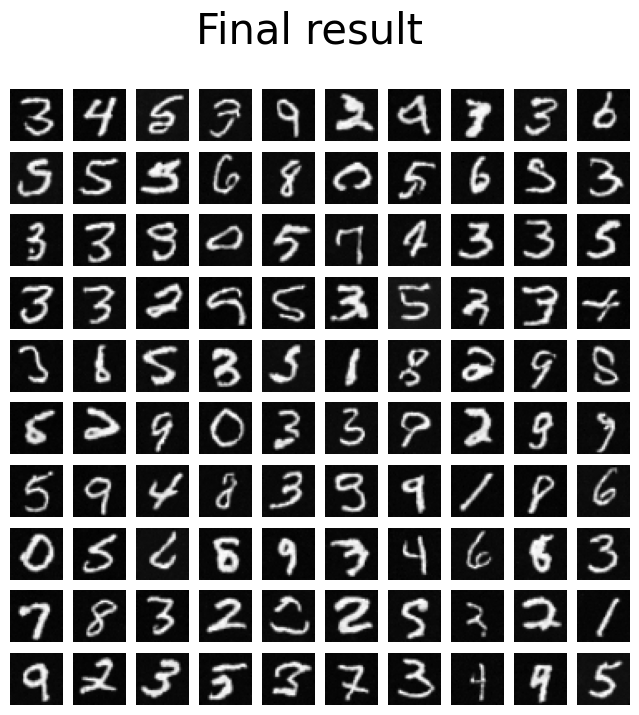

In [117]:
# Results 
generated = generate_image(model, 100, 1, 32)
show_images(generated, "Final result")

In [118]:
# Saving the model
torch.save(model.state_dict(),'model-difussion.pth')